<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/hpc_homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Heat Equation Implementation in NumPy

Consider a simple model that implements the 2d, time-dependent heat equation below.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def init_field(nx, ny, hot=1.0, block=10):
    """Initialize a 2D field with a hot square in the center."""
    u = np.zeros((ny, nx), dtype=float)
    cx, cy = nx // 2, ny // 2
    b = block // 2
    u[cy-b:cy+b, cx-b:cx+b] = hot
    return u

def heat_step_py(u, alpha):
    """Perform one explicit time step of the 2D heat equation using loops."""
    ny, nx = u.shape
    u_new = np.zeros_like(u)
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u_new[j, i] = u[j, i] + alpha * (
                u[j-1, i] + u[j+1, i] + u[j, i-1] + u[j, i+1] - 4.0 * u[j, i]
            )
    # boundaries remain zero (Dirichlet condition)
    return u_new

def heat_run_py(u0, alpha, steps):
    """Run multiple time steps, returning the final field."""
    u = u0.copy()
    for _ in range(steps):
        u = heat_step_py(u, alpha)
    return u

Here, we run the model, starting with a hot square in the middle of hte model domain which gradually diffuses over time.

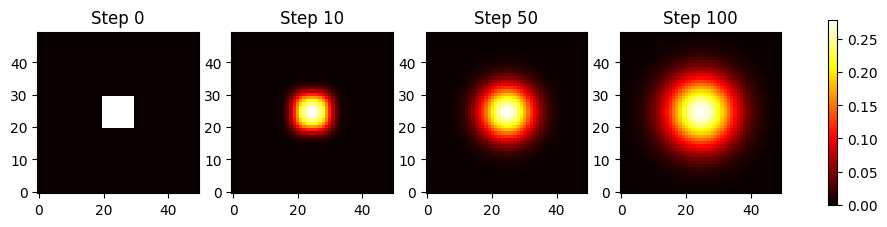

In [ ]:

# Simulation parameters
nx, ny = 50, 50
alpha = 0.24  # stable for explicit 5-point stencil
steps = 100

# Initial condition
u0 = init_field(nx, ny, hot=1.0, block=10)

# Run an example simulation
snapshots = []
u = u0.copy()
for t in range(steps+1):
    if t in (0, 10, 50, 100):
        snapshots.append((t, u.copy()))
    u = heat_step_py(u, alpha)

# Plot at a few snapshots
fig, axes = plt.subplots(1, len(snapshots), figsize=(12, 3))
for ax, (t, u_snap) in zip(axes, snapshots):
    im = ax.imshow(u_snap, origin="lower", cmap="hot")
    ax.set_title(f"Step {t}")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

**Q1.** To make this model faster, you'll create a new function called `heat_update_numpy` that performs the same operations as `heat_update_py` using NumPy.

In [ ]:
def heat_step_numpy(u, alpha):
    """
    Perform one explicit time step of the 2D heat equation using NumPy vectorization.
    Use the heat_step_py function as a reference, translating all loops to
    NumPy operations and using slicing notation.

    Parameters
    ----------
    u : ndarray of shape (ny, nx)
        Current temperature field.
    alpha : float
        Diffusion coefficient / stability parameter for the explicit scheme.

    Returns
    -------
    u_new : ndarray of shape (ny, nx)
        Updated temperature field after one time step.

    Notes
    -----
    - Update only the *interior* points of the array.
    - Apply Dirichlet boundary conditions: boundary values stay fixed at zero
    for cells on the edges of the array.
    - Do not use explicit Python loops over i, j; instead use NumPy slicing.
    """
    # TODO: replace with NumPy slicing implementation
    raise NotImplementedError("Implement here!")



**Q2.** After implementing `heat_step_numpy`, create a function that performs a full time-dependent simulation for a given number of steps. It should take in an initial condition and return a $t \times n_y \times n_x$ array where $t$ is the number of steps and $n_y \times n_x$ is the grid size.  

In [ ]:
def run_simulation(u0, alpha, step_func, steps=100):
    """
    Run a 2D heat/diffusion simulation for a fixed number of time steps.

    Parameters
    ----------
    u0 : ndarray of shape (ny, nx)
        The initial temperature field at time step 0.
    alpha : float
        Diffusion/stability parameter (D * dt / dx^2).
    step_func : callable
        A function with signature `step_func(u, alpha) -> u_new` that advances
        the field by one explicit time step. This could be a pure Python,
        NumPy, or Numba implementation.
    steps : int, optional (default=100)
        Number of time steps to simulate.

    Returns
    -------
    history : ndarray of shape (steps+1, ny, nx)
        3D array containing the full time history of the simulation.
        - history[0] = u0
        - history[k] = field after k steps for k = 1..steps

    Notes
    -----
    - Students should allocate an output array of shape (steps+1, ny, nx).
    - The first slice should be the initial condition.
    - Each subsequent slice should store the updated field from the chosen
      `step_func`.
    """
    # TODO: implement simulation loop that calls step_func
    raise NotImplementedError("Try it out!")


**Q3.** Perform simulations using the original Python stepping function `heat_step_py` and another using `heat_step_numpy` for 100 time steps. Use the same initial condition used above, and plot the outputs at steps 0, 10, 50, and 100.

**Q4.** Check that the outputs are the same at every time step whether you use `heat_step_py` or `heat_step_numpy` in the simulation.  Use the `assert_array_equal` function. If implemented correctly, the following code should show that both arrays are equal.

In [ ]:
import numpy.testing as npt

# Assert that array_a and array_b are equal (no error will be raised)
try:
    npt.assert_array_equal(history1, history2)
    print("array_a and array_b are equal.")
except AssertionError as e:
    print(f"AssertionError: {e}")

array_a and array_b are equal.


**Q5.** Perform a benchmarking test comparing simulations using `heat_step_numpy` to those using `heat_step_py` across a range of grid sizes of $64 \times 64$, $128 \times 128$, $256 \times 256$, $512 \times 512$, and $1024 \times 1024$. Create a plot showing how long simulations take for every grid size using both the pure Python approach and NumPy. For each grid size, compute the percentage speed up for NumPy for each grid size.  

# Part 2: Maze Generation Using Numba

Numba can be a good choice for implementing graph algorithms involving lots of branching behavior, which can be cumbersome to implement in NumPy. Here, we'll implement a maze generation algorithm based on Kruskal's algorithm. Kruskal's algorithm is a graph algorithm for finding a minimum spanning tree on an arbitrary graph graph.

Below you are given the `union` and find functions for a disjoint-set data structure. The disjoint-set data structure is often used in implementations of Kruskal's algorithm. This data structure contains just two functions:


1. **Find**
This operation determines the representative (or "root") of the set containing the given element. By comparing the representatives of two elements, one can ascertain if they belong to the same set.

2. **Union**
This operation merges the sets containing element1 and element2 into a single, combined set.

 You will use the `union` function in Kruskal'algorithm to determine if two nodes cells in the maze are connected.

In [ ]:
from numba import njit
import numpy as np

@njit
def find(x, parent):
    """
    Find the representative (root) of the set containing element x.

    This function traverses up the parent pointers until it reaches
    the root of the set (an element whose parent is itself). Along the way,
    it applies path compression: updating parent pointers to point directly
    to the root, which flattens the tree structure and speeds up future calls.

    Parameters
    ----------
    x : int
        The element to find the root of.
    parent : numpy.ndarray of int
        The array of parent pointers for each element.

    Returns
    -------
    int
        The index of the root element representing the set containing x.
    """
    while parent[x] != x:
        parent[x] = parent[parent[x]]  # path compression
        x = parent[x]
    return x


@njit
def union(x, y, parent, size):
    """
    Merge the sets containing elements x and y (if they are different).

    This function uses union by size: the root of the smaller set is made a
    child of the root of the larger set. This keeps the trees shallow,
    improving the efficiency of future find/union operations.

    Parameters
    ----------
    x, y : int
        The elements whose sets should be merged.
    parent : numpy.ndarray of int
        The array of parent pointers for each element.
    size : numpy.ndarray of int
        The array storing the size of the set rooted at each element.
        Only valid at root indices.

    Returns
    -------
    bool
        True if the sets were distinct and successfully merged,
        False if x and y were already in the same set.
    """
    rx, ry = find(x, parent), find(y, parent)
    if rx == ry:
        return False
    if size[rx] < size[ry]:
        rx, ry = ry, rx
    parent[ry] = rx
    size[rx] += size[ry]
    return True

**Q1**: Consider a graph that is constructed by placing nodes at the center points of an $n \times n$ grid of cells. Each cell is connected via edges to its neighboring cells to the bottom and right.  

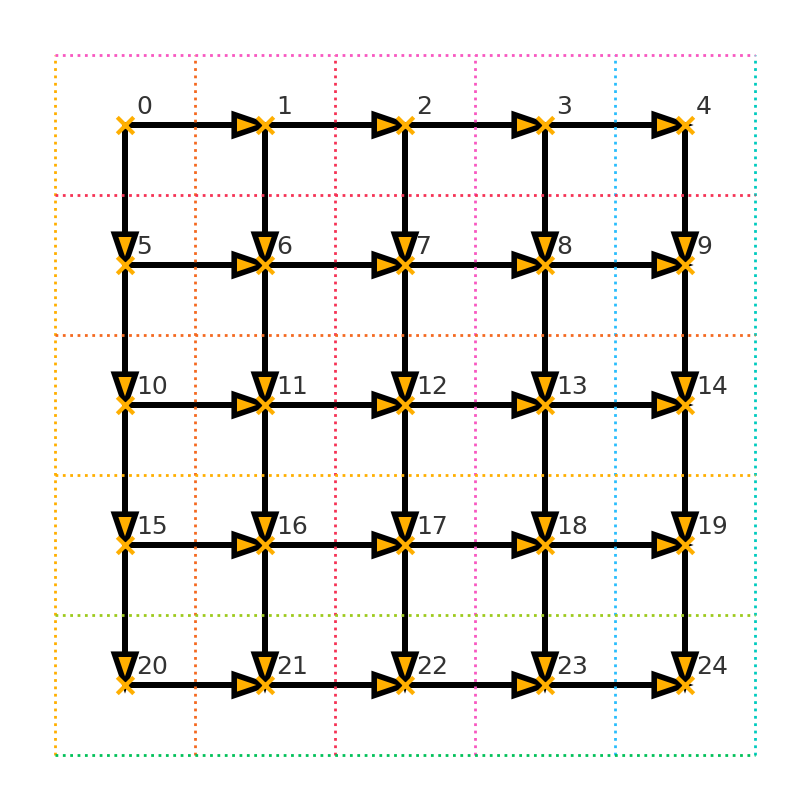



**Q2:** Create a function that uses NumPy to construct the graph of an $n \times n$ grid of cells, as shown in the diagram. The function should take a single integer argument $n$ and return the following:

1. **Cell centers:**
A NumPy array of shape $(n^2, 2)$ containing the $(x,y)$ coordinates of each cell center. The cells are laid out in row-major order, so cell index $i = r \cdot n + c$ corresponds to row $r$, column $c$. The grid covers the unit square $[0,1] \times [0,1]$, so the centers should be uniformly spaced in both directions.

2. **Edges:**
A NumPy integer array of shape $(2n(n-1), 2)$, where each row $[u, v]$ represents an undirected edge between cell $u$ and cell $v$. Each cell should be connected to its immediate right neighbor (if one exists) and its immediate bottom neighbor (if one exists). Each adjacency is listed exactly once (so you do not include both $[u,v]$ and $[v,u]$).

Example: a row $[0, 1]$ means that cell 0 is connected to cell 1 (its neighbor to the right).



> Note, the coordinates will not be used explicitly, but generating the cell center coordinates may help you think about how to generate the edges.



In [ ]:
import numpy as np

def build_grid_graph(n: int):
    """
    Construct the graph of an n x n grid of cells.

    Parameters
    ----------
    n : int
        The number of rows and columns in the grid.

    Returns
    -------
    coords : ndarray of shape (n^2, 2)
        The (x, y) coordinates of each cell center. Cells are indexed
        in row-major order: index i = r*n + c corresponds to row r,
        column c. The grid spans the unit square [0,1] x [0,1], so the
        centers are evenly spaced in both directions.

    edges : ndarray of shape (2n(n-1), 2)
        Each row [u, v] represents an undirected edge between cell u
        and cell v. Each cell should be connected to its immediate
        right neighbor (if one exists) and its immediate bottom neighbor
        (if one exists). Each adjacency is listed exactly once
        (do not include both [u,v] and [v,u]).

    Notes
    -----
    - Example: a row [0, 1] in the edges array means that cell 0
      is connected to cell 1 (its neighbor to the right).
    - Think about how to compute coordinates uniformly in [0,1] and
      how to translate (row, col) pairs into linear indices.
    """
    # TODO: Create the coords array of shape (n^2, 2)
    coords = None

    # TODO: Build the edges array of shape (2n(n-1), 2)
    edges = None

    return coords, edges

Now, you'll use Kruskal's algorithm to create a maze on an $n \times n$ grid of cells. You'll use the graph representation of the grid indicated in the diagram. In particular, each cell in the grid is treated as a node in a graph. Each possible adjacency between neighboring cells is an edge.

In the previous task, you wrote a function `build_grid_graph(n)` that returns:

* The $(x,y)$ coordinates of each cell center.
* A list of edges connecting each cell to its right and bottom neighbors.

We can think of this graph as a connectivity graph, so that if an edge exists in the graph, there is a passage between the two corresponding cells. If an edge exists in the connectivity graph, then it means there's a passage between those two cells. If an edge is removed from the graph, it means there's a wall blocking connectivity. Using this idea we can generate a maze by deciding which edges to keep and which to remove.


**Algorithm Outline**

1. **Initialization**

  * Assign each of the $n^2$ cells to its own set for the disjoint set data structure.

  * Use your `build_grid_graph(n)` function to generate the adjacency array of edges.

2. **Process Edges**
  For each edge $[u, v]$ in the shuffled list:

  * Determine the sets that $u$ and $v$ currently belong to.

  * If cells $u$ and $v$ are in different sets, then merge them and mark that edge as a ``passage`` to be retained in the connectivity graph. If an edge is kept in the graph, then it means that the wall between the two cells will be removed from the maze. Otherwise, if an edge is removed from the connectivity graph, that means a wall is blocking connectivity between those two cells.

  * If cells $u$ and $v$ are in the same set, then this edge should be removed from the graph because there would be a cycle otherwise. Removing the edge in the connectivity graph is equivalent to keeping a wall between the two cells.


3. **Termination**
* Stop when all cells belong to a single set.

The chosen edges form a spanning tree of the grid graph, which defines your maze.

**Q3:** Implement a function that takes in the number of rows / columns of grid cells $n$ as well as an $n\times(n-2)$ array of edges and implements the above maze generation algorithm in Numba.


In [ ]:
import numpy as np
from numba import njit

@njit
def kruskal_numba(n: int, edges: np.ndarray) -> np.ndarray:
    """
    Run Kruskal's algorithm on the n x n grid graph of cells.

    Parameters
    ----------
    n : int
        Grid size (n x n cells).
    edges : (E, 2) ndarray[int]
        Candidate edges between adjacent cells (row-major indices),
        already given in the order they should be processed
        (e.g., shuffled beforehand).

    Returns
    -------
    passages : (M, 2) ndarray[int]
        Array of edges kept in the spanning tree (the maze passages).
        For a connected n x n grid, expect M = n^2 - 1.

    Notes
    -----
    - Each of the n^2 cells starts in its own disjoint set.
    - Iterate over edges in the given order:
        * If the endpoints are in different sets:
            - merge their sets (union)
            - keep the edge in the result (carve a passage)
        * Otherwise skip the edge (to avoid cycles).
    - Stop early once you've kept n^2 - 1 edges.

    Hints
    -----
    - You'll need `parent` and `size` arrays to implement union–find.
    - Use helper functions `find` (with path compression)
      and `union` (with union by size) to manage disjoint sets.
    - Keep track of how many edges you have accepted so far.
    """
    # TODO: initialize disjoint set arrays (parent, size)
    # TODO: create an output array of shape (n*n-1, 2)
    # TODO: loop over edges, applying union–find logic
    # TODO: stop once n^2 - 1 edges in the connectivity graph (also called passages) are kept
    # TODO: return only the kept part of the passages array
    return np.empty((0, 2), dtype=np.int32)  # placeholder


Use the following wrapper function to call your `kruskal_numba` function, randomly shuffling the edges each time. Simple wrapper functions like these are often helpful when using Numba.

In [ ]:
def generate_maze(n: int, seed: int = 0):
    coords, edges = build_grid_graph(n)
    if edges.size:
        rng = np.random.default_rng(seed)
        rng.shuffle(edges)
    passages = kruskal_numba(n, edges)
    return coords, passages, h_walls, v_walls

You can test your implementation of the maze algorithm with this plotting function that takes in the passages chosen by Kruskal's algorithm. Essentially, if a passage between two cells exists (an edge in the connectivity graph), the wall between those two cells is not plotted. Otherwise, it is.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_maze_from_passages(n: int,
                            passages: np.ndarray,
                            entrances=None,
                            figsize_scale: float = 0.35,
                            save_path: str | None = None):
    """
    Plot an n x n maze directly from the kept edges ("passages") produced by Kruskal.

    Parameters
    ----------
    n : int
        Grid size (n x n cells).
    passages : (M, 2) array-like of int
        Each row [u, v] is a kept edge between cell indices u and v (row-major).
        Keeping an edge means the wall between those two cells is REMOVED.
    entrances : list[tuple[str, int]] | None
        Optional border gaps to create entrances/exits.
        side ∈ {'N','S','E','W'}:
          - For 'N'/'S', idx is a column in [0..n-1].
          - For 'W'/'E', idx is a row    in [0..n-1].
        Example: [('N', 0), ('S', n-1)]
    figsize_scale : float
        Figure size scale factor.
    save_path : str | None
        If provided, saves the figure to this path.

    Returns
    -------
    fig, ax : Matplotlib Figure and Axes

    Notes
    -----
    Conversion rule (cell-wise model):
      - If two cells share a ROW (horizontal adjacency), we remove the VERTICAL wall
        between them at h_walls[row, min(col_u, col_v)].
      - If they share a COLUMN (vertical adjacency), we remove the HORIZONTAL wall
        at v_walls[min(row_u, row_v), col].
    """
    passages = np.asarray(passages, dtype=np.int32)

    # Convert passages to wall grids
    h_walls = np.ones((n,   n-1), dtype=bool)   # vertical segments between (r,c)-(r,c+1)
    v_walls = np.ones((n-1, n  ), dtype=bool)   # horizontal segments between (r,c)-(r+1,c)

    if passages.size:
        u = passages[:, 0]
        v = passages[:, 1]
        ur, uc = divmod(u, n)
        vr, vc = divmod(v, n)

        same_row = (ur == vr)
        cols = np.minimum(uc, vc)
        rows = np.minimum(ur, vr)

        # Remove vertical walls for horizontal adjacencies
        h_walls[ur[same_row], cols[same_row]] = False
        # Remove horizontal walls for vertical adjacencies (uc == vc)
        mask = ~same_row
        v_walls[rows[mask], uc[mask]] = False

    fig, ax = plt.subplots(figsize=(n * figsize_scale, n * figsize_scale))

    gaps = {'N': set(), 'S': set(), 'E': set(), 'W': set()}
    if entrances:
        for side, idx in entrances:
            gaps[side].add(int(idx))

    # Outer border (skip any requested gaps)
    for c in range(n):
        if c not in gaps['N']:
            ax.plot([c, c+1], [n, n], color='black')
        if c not in gaps['S']:
            ax.plot([c, c+1], [0, 0], color='black')
    for r in range(n):
        if r not in gaps['W']:
            ax.plot([0, 0], [r, r+1], color='black')
        if r not in gaps['E']:
            ax.plot([n, n], [r, r+1], color='black')

    # Interior horizontal walls (between rows)
    for r in range(n - 1):
        y = r + 1
        for c in range(n):
            if v_walls[r, c]:
                ax.plot([c, c+1], [y, y], color='black')

    # Interior vertical walls (between columns)
    for r in range(n):
        for c in range(n - 1):
            if h_walls[r, c]:
                x = c + 1
                ax.plot([x, x], [r, r+1], color='black')

    ax.set_aspect('equal')
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.axis('off')

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0)

    return fig, ax



In [ ]:
n = 32
coords, passages, h_walls, v_walls = generate_maze(n, seed=7)
fig, ax = plot_maze_from_passages(
    n,
    passages=passages,
    entrances=[('N', 0), ('S', n-1)],  # optional entrances/exits
    figsize_scale=0.4
)
plt.show()

## Part 3: **CSCI-591 Only**
**Q1:** Implement an equivalent maze generating algorithm in pure Python. Create a similar benchmark to the one you used for the heat equation, and evaluate how long (on average) it takes to generate mazes for grids of sizes $25\times25$, $50\times50$, $100 \times 100$, and $200 \times 200$ with both Numba and pure Python. Be sure to exclude compilation time when benchmarking Numba.

## Grading Rubrick
Each question in parts 1 and 2 will be worth 5 points. Q1 in Part 3 (CSCI-591 only) will be worth 15 points total.

* **Grading criteria:**
* Correctness of heat equation and maze generation algorithms and correct incorporation of the given helper functions.  
* Proper use of NumPy functions, broadcasting, and slicing where appropriate.
* Use of the `@njit` decorator in the Kruskal maze generation algorithm.
* Code clarity and proper comments.
* Proper attribution of generative AI if applicable.
* Quality and readability for all required plots.